# Precursor Charge State Prediction

This notebook presents a short walkthrough the process of reading a dataset and training a model for precursor charge state prediction. The dataset is an example dataset extracted from a ProteomTools dataset generated in the **Chair of Bioanalytics** at the **School of Life Sciences** at the **Technical University of Munich**.

DLOmix is the framework being used here and it is a custom wrapper on top of Keras/TensorFlow and PyTorch.
This walkthrough focusses on PyTorch.

In [1]:
%env DLOMIX_BACKEND pytorch

import dlomix
dlomix.__version__

env: DLOMIX_BACKEND=pytorch
Using PyTorch Backend for DLOmix. To change the backend, set the DLOMIX_BACKEND environment variable to tensorflow or pytorch and re-import DLOmix.


'0.1.9'

The available modules in the framework are as follows:

- `constants`: constants to be used in the framework (e.g. Aminoacid alphabet mapping)
- `data`:  classes for representing dataset, wrappers around HuggingFace datasets to process input data and generate tensor datasets
- `eval`: custom evaluation metrics implemented in Keras/TF to work as `metrics` for model training
- `layers`: custom layer implementation required for the different models
- `models`: different model implementations for Retention Time Prediction
- `pipelines`: complete pipelines to run a task (e.g. Retention Time prediction)

**Note**: reports and pipelines are work-in-progress, some funtionalities are not complete.

In [2]:
from dlomix import constants, data, eval, layers, models, pipelines, reports
print([x for x in dir(dlomix) if not x.startswith("_")])


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications

['BACKEND_IMPORT_ERROR_MESSAGE', 'BACKEND_PRETTY_NAME', 'PYTORCH_BACKEND', 'TENSORFLOW_BACKEND', 'config', 'constants', 'data', 'eval', 'layers', 'losses', 'models', 'pipelines', 'reports', 'torch']


## required imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt

from dlomix.constants import PTMS_ALPHABET
from dlomix.data import ChargeStateDataset
from dlomix.models import ChargeStatePredictor

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## 1. Load Data

We can import the dataset class and create an object of type `ChargeStateDataset`. This object wraps around a Hugging Face dataset that can generate TensorFlow Dataset objects or Torch Dataset for training, validation, or testing. This can be controlled by the arguments `val_ratio`, `val_data_source`, and `test_data_source`.

The most important columns of the charge state dataset are:
* "modified_sequence", representing the peptide sequences, modifications are annotated using the UNIMOD encoding.
* "charge_state_dist", representing the relative charge state distribution per peptide. It is to be used together with the model_flavour="relative", which is the default.
* "most_abundant_charge_state", representing the most abundant charge state (as binary vector) per peptide. It is to be used together with the model_flavour="dominant".
* "observed_charge_states", representing all observed charge states (as binary vector) per peptide. It is to be used together with the model_flavour="observed".

In [5]:
DATA_PATH = "Wilhelmlab/prospect-ptms-charge"   # complete PROSPECT dataset prepared for charge state prediction, contains train, val & test splits
BATCH_SIZE = 512

In [6]:
d = ChargeStateDataset(
    data_format="hub",
    data_source=DATA_PATH,
    sequence_column="modified_sequence",
    label_column="charge_state_dist",   # use this column for relative charge state distribution
    max_seq_len=32,
    batch_size=BATCH_SIZE,
    dataset_type="pt",   # pytorch
    encoding_scheme="naive-mods",
    alphabet=PTMS_ALPHABET,
)

Applying step: SequenceParsingProcessor on split train...


/Users/Omar/Documents/VSCode_repos/dlomix/dlomix/src/dlomix/data/dataset.py:242: UserWarning: The provided data is assumed to be hosted on the Hugging Face Hub since data_format is set to "hub". Validation and test data sources will be ignored.
  warnings.warn(
/Users/Omar/Documents/VSCode_repos/dlomix/dlomix/src/dlomix/data/dataset.py:309: UserWarning: 
                Multiple data sources or a single non-train data source provided {'train': 'HF hub dataset - Wilhelmlab/prospect-ptms-charge - train', 'val': 'HF hub dataset - Wilhelmlab/prospect-ptms-charge - val', 'test': 'HF hub dataset - Wilhelmlab/prospect-ptms-charge - test'}, please ensure that the data sources are already split into train, val and test sets
                since no splitting will happen. If not, please provide only one data_source and set the val_ratio to split the data into train and val sets."
                
  warnings.warn(


Mapping SequenceParsingProcessor:   0%|          | 0/1142537 [00:00<?, ? examples/s]

Applying step: SequenceParsingProcessor on split val...


Mapping SequenceParsingProcessor:   0%|          | 0/328072 [00:00<?, ? examples/s]

Applying step: SequenceParsingProcessor on split test...


Mapping SequenceParsingProcessor:   0%|          | 0/161588 [00:00<?, ? examples/s]

Applying step: SequenceEncodingProcessor on split train...


Mapping SequenceEncodingProcessor:   0%|          | 0/1142537 [00:00<?, ? examples/s]

Applying step: SequenceEncodingProcessor on split val...


Mapping SequenceEncodingProcessor:   0%|          | 0/328072 [00:00<?, ? examples/s]

Applying step: SequenceEncodingProcessor on split test...


Mapping SequenceEncodingProcessor:   0%|          | 0/161588 [00:00<?, ? examples/s]

Applying step: SequencePaddingProcessor on split train...


Mapping SequencePaddingProcessor:   0%|          | 0/1142537 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1142537 [00:00<?, ? examples/s]

Applying step: SequencePaddingProcessor on split val...


Mapping SequencePaddingProcessor:   0%|          | 0/328072 [00:00<?, ? examples/s]

Filter:   0%|          | 0/328072 [00:00<?, ? examples/s]

Applying step: SequencePaddingProcessor on split test...


Mapping SequencePaddingProcessor:   0%|          | 0/161588 [00:00<?, ? examples/s]

Now we have an CS dataset that can be used directly with standard or custom `PyTorch` models. This wrapper contains the splits we chose when creating it. In our case, they are training and validation splits. To get the torch DataLoader, we call the attributes `.tensor_train_data` and `.tensor_val_data`.

In [7]:
print("Hugging Face Dataset:", d)

print("Training examples:", len(d["train"]))
print("one training batch looks like:")
for x in d.tensor_train_data:
    print(x)
    break

print("\nValidation examples:", len(d["val"]))
print("\nTest examples:", len(d["test"]))

Hugging Face Dataset: DatasetDict({
    train: Dataset({
        features: ['modified_sequence', 'charge_state_dist', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 1141555
    })
    val: Dataset({
        features: ['modified_sequence', 'charge_state_dist', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 327803
    })
    test: Dataset({
        features: ['modified_sequence', 'charge_state_dist', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 161588
    })
})
Training examples: 1141555
one training batch looks like:
{'modified_sequence': tensor([[21,  7, 37,  ...,  0,  0,  0],
        [56, 16, 13,  ...,  0,  0,  0],
        [56,  8, 10,  ...,  0,  0,  0],
        ...,
        [21, 13,  4,  ...,  0,  0,  0],
        [21, 23,  8,  ...,  0,  0,  0],
        [21, 20,  6,  ...,  0,  0,  0]]), 'charge_state_dist': tensor([[0.0000, 0.2754, 0.7246, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000,

## 2. Model

We can now create the model. We will use the relative charge state distribution version (set via the parameter model_flavour="relative") of the Prosit-based Precursor Charge State Prediction model `ChargeStatePredictor`. It has default working arguments, but most of the parameters can be customized.

**Note**: Important is to ensure that the padding length used for the dataset object is equal to the sequence length passed to the model.

The three model flavours of `ChargeStatePredictor` are:

1. Dominant Charge State Prediction:
   - Task: Predict the dominant charge state of a given peptide sequence.
   - Model: Uses a deep learning model (RNN-based) inspired by Prosit's architecture to predict the most likely charge state.

2. Observed Charge State Prediction:
   - Task: Predict the observed charge states for a given peptide sequence.
   - Model: Uses a multi-label classification approach to predict all possible charge states.

3. Relative Charge State Prediction:
   - Task: Predict the proportion of each charge state for a given peptide sequence.
   - Model: Uses a regression approach to predict the proportion of each charge state.

In [8]:
model = ChargeStatePredictor(
    num_classes=6, seq_length=32, alphabet=PTMS_ALPHABET, model_flavour="relative"
)

model.to(device)

ChargeStatePredictor(
  (final_activation): Identity()
  (embedding): Embedding(57, 16, padding_idx=0)
  (encoder): BiGRUSequentialEncoder(
    (bidirectional_GRU): GRU(16, 256, batch_first=True, bidirectional=True)
    (encoder_dropout1): Dropout(p=0.5, inplace=False)
    (unidirectional_GRU): GRU(512, 512, batch_first=True)
    (encoder_dropout2): Dropout(p=0.5, inplace=False)
  )
  (attention): AttentionLayer()
  (regressor): Sequential(
    (dense): Linear(in_features=512, out_features=512, bias=True)
    (activation_relu): ReLU()
    (regressor_dropout): Dropout(p=0.1, inplace=False)
  )
  (output_layer): Linear(in_features=512, out_features=6, bias=True)
  (activation): Identity()
)

In [9]:
criterion = nn.MSELoss()  # for relative CSD
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## 3. Training

We can then train the model using a custom training loop. You can observe the decreasing loss value

In [10]:
# Learning rate scheduler.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.1,  # lr factor
    patience=2,  # lr patience
    min_lr=1e-7,
)

# Early stopping tracking.
best_val_loss = float("inf")
epochs_without_improvement = 0
best_model_state = None

# Prepare a list to store metrics per epoch for CSV logging.
metrics_log = []  # Each element will be a dict with keys: epoch, train_loss, val_loss, learning_rate

In [11]:
# Training and Validation
# -------------------------

for epoch in range(1, 3):  # reduced for demonstration
    model.train()
    running_loss = 0.0
    local_step = 0

    for batch in d.tensor_train_data:
        train_seq = batch["modified_sequence"]
        train_label = batch["charge_state_dist"]

        # Ensure tensors are on the correct device and type
        train_seq = train_seq.to(device, dtype=torch.int32)
        train_label = train_label.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        pred_cs = model(train_seq)
        loss = criterion(pred_cs, train_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if local_step % 100 == 0:
            avg_loss = running_loss / (local_step + 1)
            print(f"Epoch {epoch}, Step {local_step}, Training Loss: {avg_loss:.4f}")
        local_step += 1

    avg_train_loss = running_loss / len(d.tensor_train_data)

    # Validation phase.
    model.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for batch in d.tensor_val_data:
            val_seq = batch["modified_sequence"]
            val_label = batch["charge_state_dist"]

            # Ensure tensors are on the correct device and type
            val_seq = val_seq.to(device, dtype=torch.int32)
            val_label = val_label.to(device, dtype=torch.float32)

            val_pred_cs = model(val_seq)
            val_loss = criterion(val_pred_cs, val_label)
            val_loss_total += val_loss.item()

            # TODO add adjusted_mean_absolute_error metric

    avg_val_loss = val_loss_total / len(d.tensor_val_data)
    print(
        f"Epoch {epoch} Summary: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
    )

    # Learning rate scheduler using the validation loss.
    scheduler.step(avg_val_loss)
    current_lr = scheduler.optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch}: Current Learning Rate: {current_lr}")

    # Early stopping check.
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")
        if epochs_without_improvement >= 5:  # patience
            print("Early stopping triggered.")
            # Log current epoch metrics before breaking.
            metrics_log.append(
                {
                    "epoch": epoch,
                    "train_loss": avg_train_loss,
                    "val_loss": avg_val_loss,
                    "test_loss": None,
                    "learning_rate": current_lr,
                }
            )
            break

    # Log metrics for the current epoch.
    metrics_log.append(
        {
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "learning_rate": current_lr,
        }
    )

Epoch 1, Step 0, Training Loss: 0.1645
Epoch 1, Step 100, Training Loss: 0.0903
Epoch 1, Step 200, Training Loss: 0.0773
Epoch 1, Step 300, Training Loss: 0.0653
Epoch 1, Step 400, Training Loss: 0.0564
Epoch 1, Step 500, Training Loss: 0.0502
Epoch 1, Step 600, Training Loss: 0.0456
Epoch 1, Step 700, Training Loss: 0.0421
Epoch 1, Step 800, Training Loss: 0.0394
Epoch 1, Step 900, Training Loss: 0.0371
Epoch 1, Step 1000, Training Loss: 0.0353
Epoch 1, Step 1100, Training Loss: 0.0337
Epoch 1, Step 1200, Training Loss: 0.0324
Epoch 1, Step 1300, Training Loss: 0.0312
Epoch 1, Step 1400, Training Loss: 0.0302
Epoch 1, Step 1500, Training Loss: 0.0293
Epoch 1, Step 1600, Training Loss: 0.0285
Epoch 1, Step 1700, Training Loss: 0.0278
Epoch 1, Step 1800, Training Loss: 0.0272
Epoch 1, Step 1900, Training Loss: 0.0266
Epoch 1, Step 2000, Training Loss: 0.0260
Epoch 1, Step 2100, Training Loss: 0.0255
Epoch 1, Step 2200, Training Loss: 0.0250
Epoch 1 Summary: Train Loss: 0.0249, Validatio

In [12]:
# Restore the best model.
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model state.")


train_val_metrices_df = pd.DataFrame(metrics_log)
display(train_val_metrices_df.head())

Loaded best model state.


,epoch,train_loss,val_loss,learning_rate
0,1,0.024894,0.014605,0.0001
1,2,0.013670,0.011533,0.0001


### Visualize Training History

In [13]:
def plot_learning_curves(metric_df, title='Learning Curves'):
    
    plt.figure()
    plt.plot(
        metric_df["epoch"], 
        metric_df["train_loss"], 
        'b-', 
        label='Training Loss'
    )
    plt.plot(
        metric_df["epoch"], 
        metric_df["val_loss"],
        'r-', 
        label='Validation Loss'
    )
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

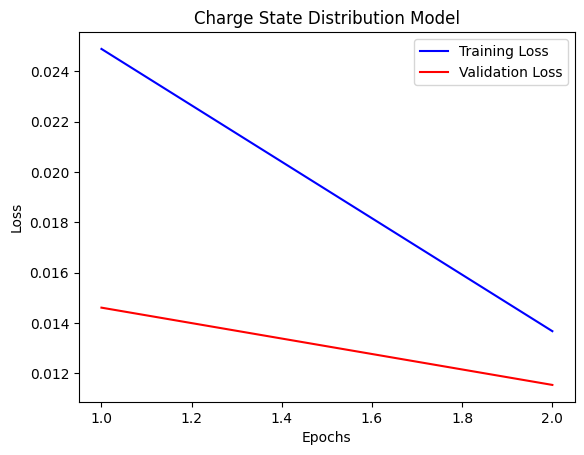

In [14]:
plot_learning_curves(train_val_metrices_df, title='Charge State Distribution Model')

## 3. Testing

The ChargeStateDataset also contains a test dataset to test our model.

**Note**: Currently there is no reporting module available for CS prediction.

In [15]:
metrics_log_test= []

model.eval()

test_loss_total = 0.0
with torch.no_grad():
    for batch in d.tensor_test_data:
        test_seq = batch["modified_sequence"]
        test_label = batch["charge_state_dist"]

        # Ensure tensors are on the correct device and type
        test_seq = test_seq.to(device, dtype=torch.int32)
        test_label = test_label.to(device, dtype=torch.float32)

        test_pred_cs = model(test_seq)
        test_loss = criterion(test_pred_cs, test_label)

        test_loss_total += test_loss.item()
avg_test_loss = test_loss_total / len(d.tensor_test_data)
print(f"Test Loss: {avg_test_loss:.4f}")

# Append final test metrics as an extra row in our log.
metrics_log_test.append(
    {
        "epoch": "test",
        "test_loss": avg_test_loss,
    }
)

print("first 5 test sequences:\n", test_seq[:5])
print("first 5 test relative charge state vectors (label):\n", test_label[:5])
print("first 5 relative charge state predictions for test:\n", test_pred_cs[:5])
print(
    "predictions.shape for test set:",
    test_pred_cs.shape,
    "number of test CS vectors (label):",
    len(test_label),
)

Test Loss: 0.0116
first 5 test sequences:
 tensor([[21, 18,  6,  9,  4,  3, 16, 24, 16, 17,  4,  5, 18,  4,  9, 22,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [21, 10,  1, 16, 20,  9, 16, 20, 16, 16, 17,  5,  7, 16, 10,  4,  4, 14,
         14, 18, 37, 23,  1, 18,  3,  8,  6, 15, 22,  0,  0,  0],
        [21,  8,  1,  8,  3,  7, 12, 14, 23,  5, 14, 20,  5,  8, 17, 18, 18, 13,
         17,  9, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [21, 12, 15,  1, 10, 20,  3,  1, 23,  1,  1,  3,  4, 15, 18, 22,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [56, 12, 10, 18, 13,  4,  4,  1,  3,  4,  7, 10,  5,  1, 10,  4, 55, 22,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
       device='mps:0', dtype=torch.int32)
first 5 test relative charge state vectors (label):
tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.

In [16]:
from dlomix.eval import adjusted_mean_absolute_error
adjusted_mean_absolute_error(test_pred_cs, test_label)

tensor(0.1190, device='mps:0')

## 4. Saving and Loading Models

Models can be saved normally the same Keras models would be saved. It is better to save the weights and the not the model since it makes it easier and more platform-indepdent when loading the model again. The extra step needed is to create a model object and then load the weights.

In [17]:
# save the models state_dict (contains all the weights and biases of the model)

save_path = "./output/csd_model_state_dict.pt"
torch.save(model.state_dict(), save_path)

In [18]:
# models can be later loaded by creating a model object and then loading the weights

# initialize model
loaded_model = ChargeStatePredictor(
    num_classes=6, seq_length=32, alphabet=PTMS_ALPHABET, model_flavour="relative"
)

# load trained model states
state_dict = torch.load(save_path)
loaded_model.load_state_dict(state_dict)

<All keys matched successfully>